Segmentation : Identifier des déchets sur une image
===========

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random

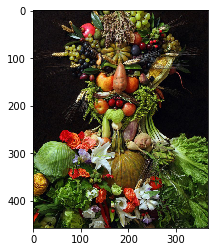

(458, 368, 3)


In [22]:
#path="trash_image.jpg"
#path="cas_simple.png"
path="Arcimboldo.jpg"

# Redimensionnement de l'image
resize_ratio =0.5
img=cv2.resize(cv2.imread(path,1), (0,0), fx=resize_ratio, fy=resize_ratio)
img_out = np.copy(img)
img=img.astype(np.uint8)

# Affichage (conversion en RGB)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb,interpolation='nearest')
plt.show()

lab=cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
print(rgb.shape)

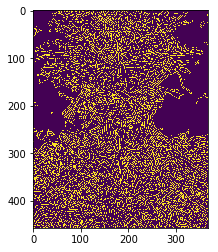

In [23]:
# Application d'un filtre de Canny

blurred = cv2.GaussianBlur(rgb, (5, 5), 0)

edged = cv2.Canny(blurred, 0, 20)

plt.imshow(edged)
plt.show()

In [18]:
# inspiré de https://github.com/agamdeep/Mean-Shift-Segmentation-using-Python/blob/master/meanshift.without.boundary.py
img,iter,threshold,current_mean_random,print_mode = lab,1.0,100, True, True
row=img.shape[0]
col=img.shape[1]

J= row * col
Size = row,col,3
R = np.zeros(Size, dtype= np.uint8)
Objects=list()
D=np.zeros((J,5))
arr=np.array((1,3))

counter=0

sq_threshold=threshold**2

current_mean_arr = np.zeros((1,5))
below_threshold_arr=[]

# Construction de l'espace des caractéristiques
for i in range(row):
    for j in range(col):      
        arr= img[i][j]
        D[counter][0]=arr[0]
        D[counter][1]=arr[1]
        D[counter][2]=arr[2]
        D[counter][3]=i
        D[counter][4]=j
        counter+=1
initial_size=len(D)
while(len(D) > 0):
    print(len(D)/initial_size)
#selecting a random row from the feature space and assigning it as the current mean    
    if(current_mean_random):
        current_mean= random.randint(0,len(D)-1)
        for i in range(0,5):
            current_mean_arr[0][i] = D[current_mean][i]
    below_threshold_arr=[]
    for i in range(len(D)):
        ecl_dist = 0
        color_total_current = 0
        color_total_new = 0
#Finding the eucledian distance of the randomly selected row i.e. current mean with all the other rows
        for j in range(5):
            ecl_dist += ((current_mean_arr[0][j] - D[i][j])**2)
                
        ecl_dist = ecl_dist**0.5

#Checking if the distance calculated is within the threshold. If yes taking those rows and adding 
#them to a list below_threshold_arr
      
        if(ecl_dist < threshold):
            below_threshold_arr.append(i)
    
    mean_R=0
    mean_G=0
    mean_B=0
    mean_i=0
    mean_j=0
    current_mean = 0
    mean_col = 0
    
#For all the rows found and placed in below_threshold_arr list, calculating the average of 
#Red, Green, Blue and index positions.
    
    for i in range(0, len(below_threshold_arr)):
        mean_R += D[below_threshold_arr[i]][0]
        mean_G += D[below_threshold_arr[i]][1]
        mean_B += D[below_threshold_arr[i]][2]
        mean_i += D[below_threshold_arr[i]][3]
        mean_j += D[below_threshold_arr[i]][4]   
    
    mean_R = mean_R / len(below_threshold_arr)
    mean_G = mean_G / len(below_threshold_arr)
    mean_B = mean_B / len(below_threshold_arr)
    mean_i = mean_i / len(below_threshold_arr)
    mean_j = mean_j / len(below_threshold_arr)
    
#Finding the distance of these average values with the current mean and comparing it with iter

    mean_e_distance = ((mean_R - current_mean_arr[0][0])**2 + (mean_G - current_mean_arr[0][1])**2 + (mean_B - current_mean_arr[0][2])**2 + (mean_i - current_mean_arr[0][3])**2 + (mean_j - current_mean_arr[0][4])**2)
    
    mean_e_distance = mean_e_distance**0.5
    
    

    nearest_i = 0
    min_e_dist = 0
    counter_threshold = 0
# If less than iter, find the row in below_threshold_arr that has i,j nearest to mean_i and mean_j
#This is because mean_i and mean_j could be decimal values which do not correspond
#to actual pixel in the Image array.

    if(mean_e_distance < iter):
                
        new_arr = np.zeros((1,3))
        new_arr[0][0] = mean_R
        new_arr[0][1] = mean_G
        new_arr[0][2] = mean_B
        
# When found, color all the rows in below_threshold_arr with 
#the color of the row in below_threshold_arr that has i,j nearest to mean_i and mean_j
        for i in range(0, len(below_threshold_arr)):    
            R[int(D[below_threshold_arr[i]][3])][int(D[below_threshold_arr[i]][4])] = new_arr
            
# Also now don't use those rows that have been colored once.
            
            D[below_threshold_arr[i]][0] = -1
        current_mean_random = True
        new_D=np.zeros((len(D),5))
        counter_i = 0
        
        i_min=None
        i_max=None
        j_min=None
        j_max=None
        pixels=[]
        pixel_count=0
        for i in range(0, len(D)):
            if(D[i][0] != -1):
                new_D[counter_i][0] = D[i][0]
                new_D[counter_i][1] = D[i][1]
                new_D[counter_i][2] = D[i][2]
                new_D[counter_i][3] = D[i][3]
                new_D[counter_i][4] = D[i][4]
                counter_i += 1
            else:
                pixels.append([D[i][3],D[i][4]])
                if i_min is None:
                    i_min=D[i][3]
                    i_max=D[i][3]
                    j_min=D[i][4]
                    j_max=D[i][4]
                i_min=min(i_min, D[i][3])
                i_max=max(i_max, D[i][3])
                j_min=min(j_min, D[i][4])
                j_max=max(j_max, D[i][4])
                pixel_count+=1
        Objects.append([i_min,i_max,j_min,j_max, pixel_count, pixels])
            
        
        D=np.zeros((counter_i,5))
        
        counter_i -= 1
        for i in range(0, counter_i):
            D[i][0] = new_D[i][0]
            D[i][1] = new_D[i][1]
            D[i][2] = new_D[i][2]
            D[i][3] = new_D[i][3]
            D[i][4] = new_D[i][4]
        
    else:
        current_mean_random = False
         
        current_mean_arr[0][0] = mean_R
        current_mean_arr[0][1] = mean_G
        current_mean_arr[0][2] = mean_B
        current_mean_arr[0][3] = mean_i
        current_mean_arr[0][4] = mean_j
        


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.8812535599012721
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.7508721758116574
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.6379877064742738
0.5490317068539966
0.5490317068539966
0.5490317068539966
0.5490317068539966
0.5490317068539966
0

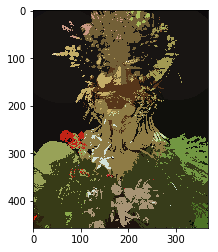

True

In [20]:
# Conversion des régions identifiées en RGB pour affichage
r_lab_rgb=cv2.cvtColor(R, cv2.COLOR_LAB2RGB)
plt.imshow(r_lab_rgb)
plt.show()
cv2.imwrite('Arcimboldo_05_100.png',cv2.cvtColor(R, cv2.COLOR_LAB2BGR))

In [12]:
len(Objects # Nombre de segments identifiés

285

In [13]:
# Sélection des 20 objets avec le plus de pixels
selected_Objects= sorted(Objects,key=lambda x:x[4], reverse=True)
if len(selected_Objects)>20:
    selected_Objects=selected_Objects[:20]

In [14]:
# Constitution de carrés (avec un padding de blanc)
pretreated_Objects=[]
for i_min,i_max,j_min,j_max, pixel_count, pixels in selected_Objects:
    size = max(int(i_max-i_min+1), int(j_max-j_min+1))
    pretreated_object=np.ones((size, size,3))*255
    for i_p, j_p in pixels:
        pretreated_object[int(i_p-i_min), int(j_p-j_min),:]=rgb[int(i_p), int(j_p),:]
    pretreated_Objects.append(pretreated_object)

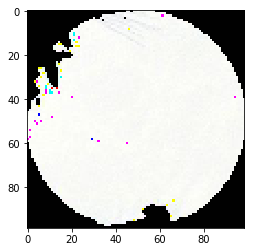

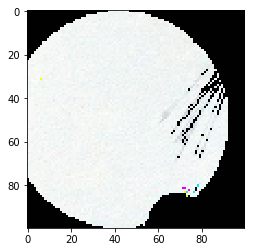

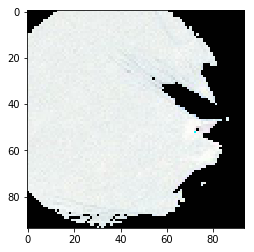

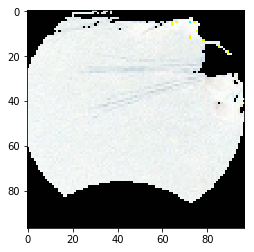

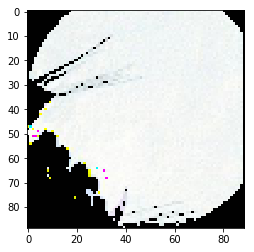

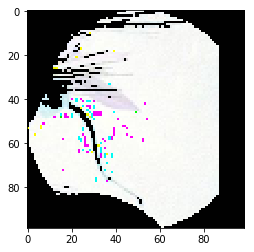

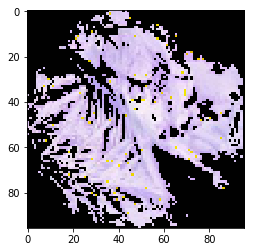

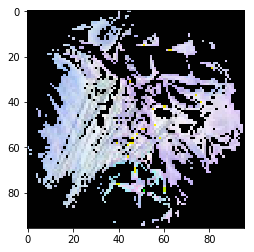

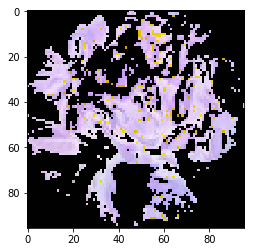

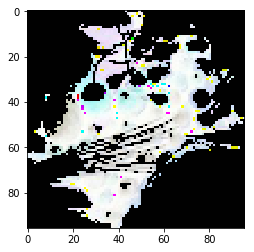

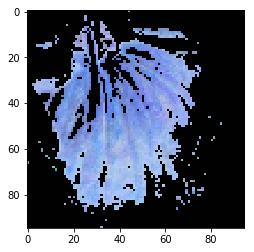

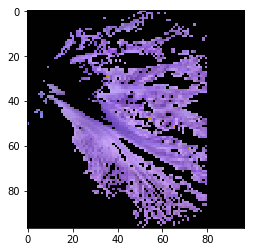

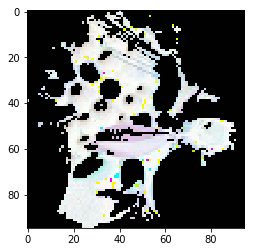

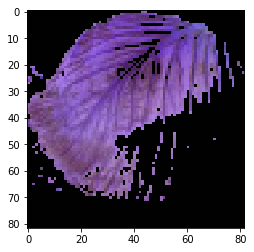

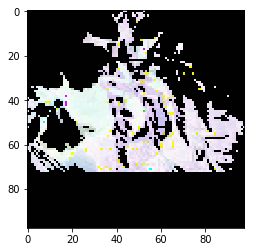

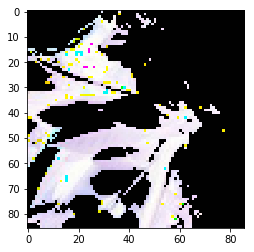

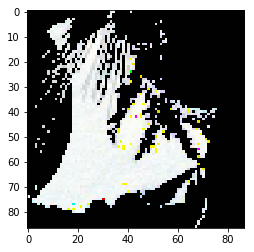

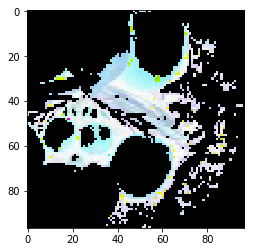

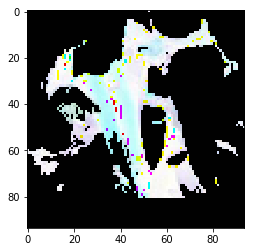

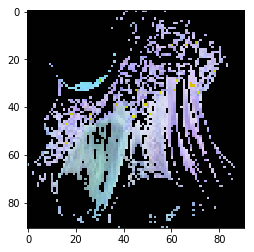

In [15]:
# Affichage des objets sélectionnés (/!\ mauvaise couleur)
for obj_rgb in pretreated_Objects:
    plt.imshow(obj_rgb, interpolation ='nearest')
    plt.show()

In [16]:
# Enregistrement des objets identifiés et pertinents
for i,obj_rgb in enumerate(pretreated_Objects):
    cv2.imwrite('./Objets/Arcimboldo1_'+str(i)+'.png',obj_rgb)
    

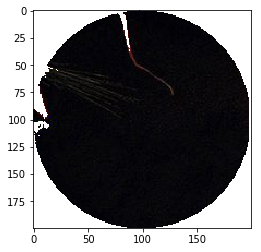

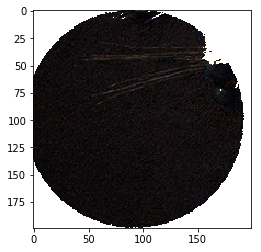

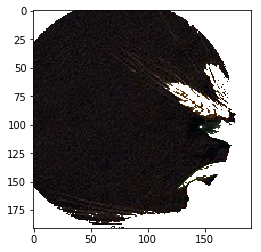

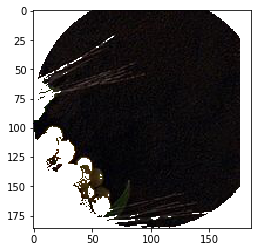

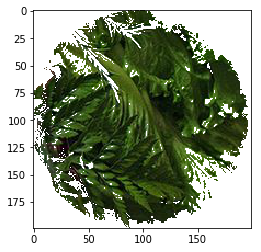

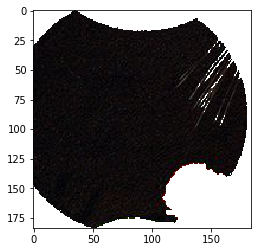

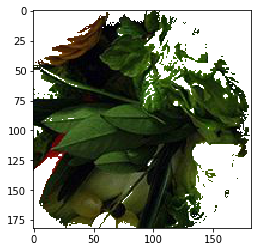

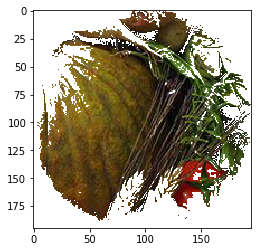

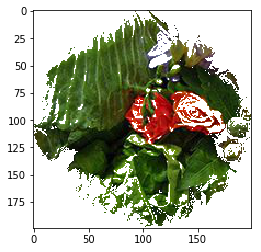

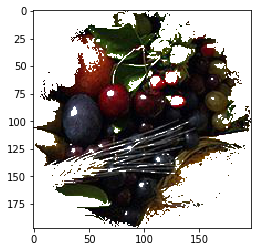

In [17]:
# Relecture des fichiers enregistrés(/!\ bonne couleur)
for i in range(10):
    rgb=cv2.imread('./Objets/Arcimboldo1_'+str(i)+'.png',1)
    plt.imshow(rgb)
    plt.show()